# Automatic refinement of elements

---

_Developed by D.A. Brakenhoff, December 2023, Artesia + TU Delft_


This notebook shows how elements can be automatically refined in TimML. 

## Contents

- [Supported elements](#supported-elements)
- [User added elements vs. refined elements](#user-added-elements-vs-refined-elements)
- [Single line-sink](#single-line-sink)
- [Compound line-sinks](#compound-line-sinks)
- [Compound line-sink with nearby well](#compound-line-sink-with-nearby-well)
- [Refining inhomogeneities: LeakyBuildingPit](#refining-inhomogeneities-leakybuildingpit)
- [Global refine option](#global-refine-option)

Refinement means splitting line elements into smaller sub-elements. This can be
necessary for computational accuracy at locations where elements lie close together.
The sub-elements derive their properties from the original user-specified elements.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timml as tml
from timml.util import refine_n_segments

## Supported elements

The following elements support automatic refinement:

* Line-sinks and line-doublets:
    * LineSinkBase
    * HeadLineSink
    * HeadLineSinkString
    * LineSinkDitchString
    * ImpLineDoublet
    * ImpLineDoubletString
    * LeakyLineDoublet
    * LeakyLineDoubletString
* Inhomogeneities:
    * PolygonInhomMaq
    * PolygonInhom3D
    * BuildingPitMaq
    * BuildingPit3D
    * LeakyBuildingPitMaq
    * LeakyBuildingPit3D

## User added elements vs. refined elements

In order to support automatic refinement, TimML now distinguishes between elements
added to a model by the user, and elements used in the computation. When automatic
refinement is applied, in some cases, new elements are created and added to the
computation list. When an element is not refined, the original user specified element
is passed on to the computation list.

User-specified elements are stored under `ml.elements`:

In [2]:
ml = tml.ModelMaq()
ls = tml.HeadLineSink(ml, refine_level=2)

ml.elements  # user-specified elements

[HeadLineSink from (-1.0, 0.0) to (1.0, 0.0)]

The computation element list (`ml.elementlist`) is empty until the model is initialized
(or solved).

In [3]:
ml.elementlist

[]

Initialize the model

In [4]:
ml.initialize()

Note that the computation list has been filled, in this case with 2 refined elements
based on the original HeadLineSink:

In [5]:
ml.elementlist

[HeadLineSink from (-1.0, 0.0) to (6.123233995736766e-17, 0.0),
 HeadLineSink from (6.123233995736766e-17, 0.0) to (1.0, 0.0)]

## Single line-sink

Supported elements can be refined by passing the `refine_level` kwarg. A refinement
level of 0 or 1 means no refinement is applied. A refinement level of 3 means that a
line-sink is split into 3 segments. The segmentation is performed according to an
adjusted version of the cosine rule (the same method that determines the location of
the control points for a line element in TimML).

In this example a single `HeadLineSink` is refined into 3 segments. The head along the
line-sink is compared to a case with no refinement.

First we define some model parameters. We have a single semi-confined aquifer split
into two 10 m-thick layers, with 1 day resistance between the two layers. The confining
layer has resistance of 1000 days with head of 0 m+ref above the confining layer.

In [6]:
# model parameters

kh = 10  # m/day

ctop = 1000.0  # resistance top leaky layer in days

ztop = 0.0  # surface elevation
zbot = -20.0  # bottom elevation of the model
z = np.array([ztop + 1, ztop, -10, -10, zbot])

Build and store the models. Note that the only change required to apply the automatic
refinement is to supply a `refine_level>1` to the `HeadLineSink` element.

In [7]:
models = []

for rlvl in [1, 3]:
    ml = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
    ls = tml.HeadLineSink(ml, 0, 0, 10, 10, hls=1.0, refine_level=rlvl)
    ml.solve(silent=True)
    models.append(ml)

Plot a top-view of the model.

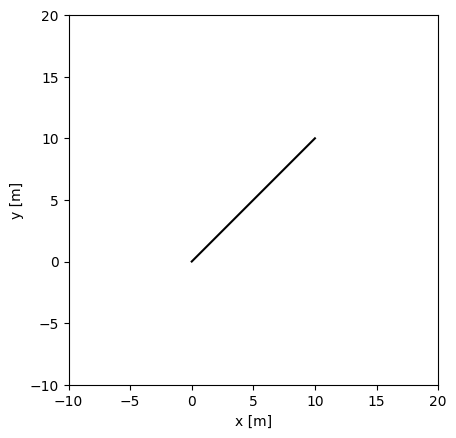

In [8]:
models[0].plots.topview([-10, 20, -10, 20])
plt.xlabel("x [m]")
plt.ylabel("y [m]");

Compare the head along the element for the refined and non-refined models. The refined
element has three points at which the head condition is specified, whereas the initial
element of order 0 has just 1 control point.

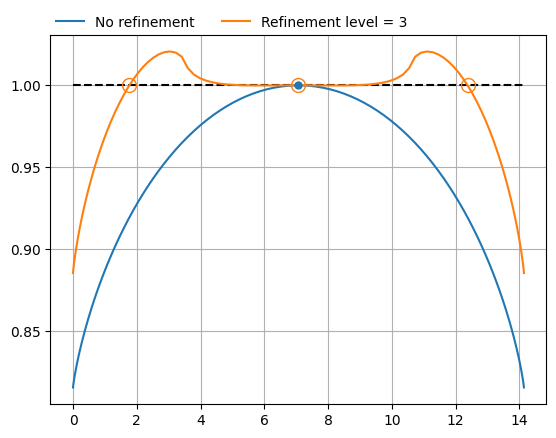

In [9]:
# compute distance along line-sink
xy = np.array([(0, 0), (10, 10)])
x, y = refine_n_segments(xy, "line", 101)[0].T
r = np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)

# loop over models
for i, iml in enumerate(models):
    h = iml.headalongline(x, y)
    if i == 0:
        lbl = "No refinement"
        # plot head condition
        plt.plot([0, r[-1]], [ls.hls, ls.hls], ls="dashed", color="k")
    else:
        lbl = f"Refinement level = {ls.refine_level}"

    # plot head
    plt.plot(r, h[0], c=f"C{i}", label=lbl)

    # plot locations control points
    for e in iml.elementlist:
        if isinstance(e, tml.HeadLineSink):
            rc = np.sqrt((e.xc - x[0]) ** 2 + (e.yc - y[0]) ** 2)
            if i == 0:
                plt.plot(rc, ls.hls, f"C{i}o", ms=5, zorder=5)
            else:
                plt.plot(rc, ls.hls, f"C{i}o", ms=10, mfc="none", zorder=5)
leg = plt.legend(loc=(0, 1), frameon=False, ncol=2)
plt.grid(True)

<div class="alert alert-block alert-warning"><b>Note: </b> 
Be careful when refining single line-sinks! The variable referring to the original
element is not the one used in the calculations! See below for more information. 
</div>

When refining a single line-sink, the TimML creates new refined elements internally. This means that the original user-specified line-sink was not used in the computation and cannot be used for calculations, e.g. getting the discharge of the line-sink.


This means the following will not work:

In [10]:
ls = models[1].elements[-1]  # get user-specified element from refined model


# NOTE: since the original element is never used in computation, it is never
# initialized and will throw an error when trying to do computations with it.
try:
    ls.discharge()
except Exception as e:
    print(e.__class__.__name__, e)

AttributeError 'NoneType' object has no attribute 'naq'


Instead do this:

In [11]:
# the refined HeadLineSink elements are the last three in the elementlist
models[1].elementlist

[ConstantStar with head  0.0,
 HeadLineSink from (0.0, 0.0) to (2.499999999999999, 2.499999999999999),
 HeadLineSink from (2.499999999999999, 2.499999999999999) to (7.5, 7.5),
 HeadLineSink from (7.5, 7.5) to (10.0, 10.0)]

In [12]:
Q = np.zeros(models[1].aq.naq)  # 2 layers
for e in models[1].elementlist[1:]:  # loop through computation (refined) elements
    Q += e.discharge()
Q

array([-204.24637731,    0.        ])

Another (better) method to avoid this issue is to use compound line-sink elements, such as
`HeadLineSinkString`, which is shown in the next section.

## Compound line-sinks

Compound line-sinks are elements that consist of multiple line-sinks, e.g.
`HeadLineSinkString`. Refining these elements works similar to the example for a single
line-sink. 

<div class="alert alert-block alert-info"><b>Tip: </b> 
The advantage of compound elements is that they store their own list of
sub-elements internally, which means the original element can be used for further
computation, unlike the example with a single line-sink.
</div>


In this example we have the same single line-sink as the previous example, but the
specified head is 1 m+ref at the starting point and 0 m+ref at the end of the line-sink.
Because the head is sloping we need more than 1 control point in the non-refined model,
so we increase the order of the element to 2. That model is compared to a refined model
with a refine_level of 3 and order 0.

Build the models

In [13]:
models = []

for rlvl, order in zip([1, 3], [2, 0], strict=False):
    ml = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
    ls = tml.HeadLineSinkString(
        ml, xy=[(0, 0), (10, 10)], hls=[1.0, 0.0], refine_level=rlvl, order=order
    )
    ml.solve(silent=True)
    models.append(ml)

Compare the head contours between the two models. As expected they look quite similar.

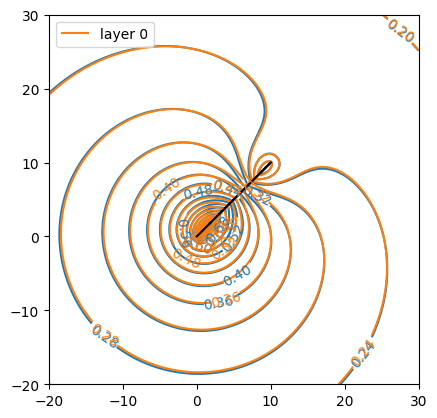

In [14]:
models[-1].plots.topview([-20, 30, -20, 30])
for i, iml in enumerate(models):
    iml.plots.contour([-20, 30, -20, 30], 101, newfig=False, decimals=2, color=f"C{i}")

As mentioned previously, the advantage of compound line-sinks is that the original
reference to the line-sink that was specified by the user can be used for computation.

In [15]:
# the HeadLineSinkString is the second element in ml.elements
models[0].elements

[ConstantStar with head  0.0,
 HeadLineSinkString with nodes [[ 0.  0.]
  [10. 10.]]]

In [16]:
# non-refined model
models[0].elements[1].discharge()

array([-102.31796071,    0.        ])

In [17]:
# refined model
models[1].elements[1].discharge()

array([-102.12318866,    0.        ])

## Compound line-sink with nearby well

In this example a well is pumping near a head-specified line-sink. We apply different
refinement levels and observe the effect on the total discharge of the line-sink. 

First specify the line-sink and well coordinates.

In [18]:
xy = np.array([(0, 0), (10, 10), (20, 10)])  # line-sink coordinates

xw, yw = 15, 0  # well coordinates
rw = 0.3  # well radius, in m
Qw = 100.0  # well discharge, in m3/d

Plot a top-view of the model

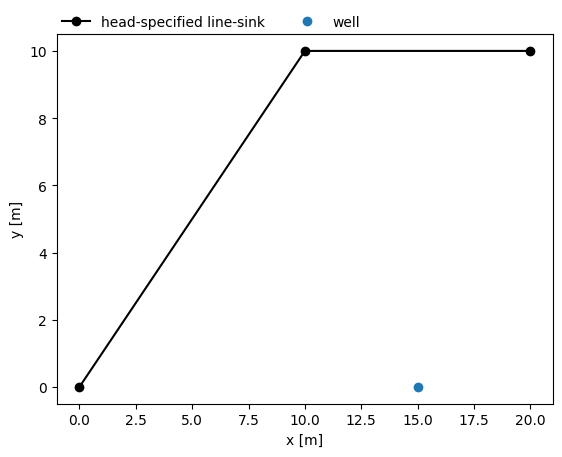

In [19]:
plt.plot(xy[:, 0], xy[:, 1], "k-o", label="head-specified line-sink")
plt.plot(xw, yw, "C0o", label="well")
leg = plt.legend(loc=(0, 1), frameon=False, ncol=2)
plt.xlabel("x [m]")
plt.ylabel("y [m]");

Build models and apply refinement levels 1-9. Print the total discharge of the line-sink for each model. After level 4, the discharge does not change by all that much any more. 

In [20]:
models = []
for rlvl in range(1, 10):
    ml = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
    hls = tml.HeadLineSinkString(ml, xy, hls=[2, 1], refine_level=rlvl)
    w = tml.Well(ml, xw, yw, Qw, rw=0.1, layers=[0])
    ml.solve(silent=True)
    models.append(ml)
    print(f"Refinement level {rlvl}: Qls = {hls.discharge().sum():.2f}")

Refinement level 1: Qls = -418.22
Refinement level 2: Qls = -428.80
Refinement level 3: Qls = -434.54
Refinement level 4: Qls = -437.01
Refinement level 5: Qls = -438.26
Refinement level 6: Qls = -438.99
Refinement level 7: Qls = -439.43
Refinement level 8: Qls = -439.73
Refinement level 9: Qls = -439.94


Compare the head contours for the first (non-refined) and last model (`refine_level=9`)

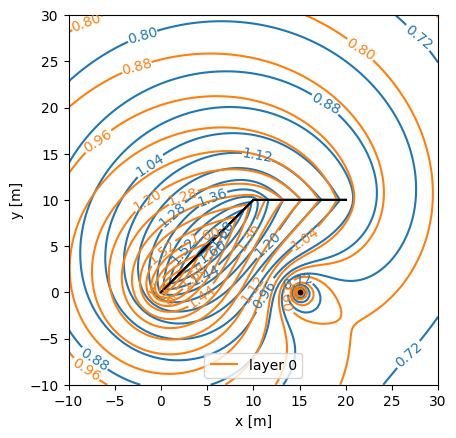

In [21]:
models[0].plots.topview([-10, 30, -10, 30])
models[0].plots.contour([-10, 30, -10, 30], 101, newfig=False, decimals=2, color="C0")
models[-1].plots.contour([-10, 30, -10, 30], 101, newfig=False, decimals=2, color="C1")

plt.xlabel("x [m]")
plt.ylabel("y [m]");

Compare the head along the line-sink to the specified head-conditions for each model.

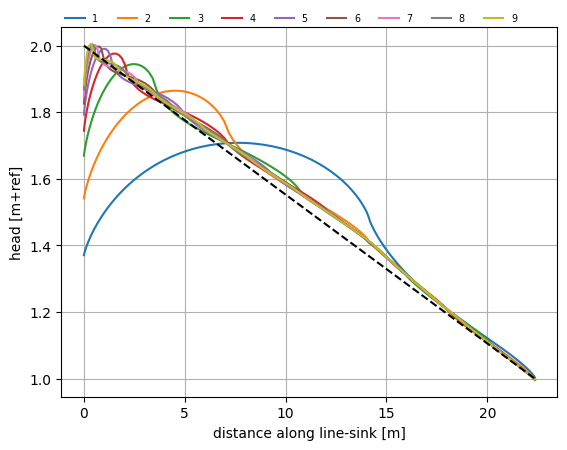

In [22]:
for i, iml in enumerate(models):
    x, y = refine_n_segments(xy, "line", 101)[0].T
    r = np.sqrt((x - x[0]) ** 2 + (y - y[0]) ** 2)
    h = iml.headalongline(x, y)
    plt.plot(r, h[0], c=f"C{i}", label=f"{i + 1}")

plt.plot(r[[0, -1]], hls._hls[[0, -1]], ls="dashed", color="k")
plt.xlabel("distance along line-sink [m]")
plt.ylabel("head [m+ref]")
plt.legend(loc=(0, 1), frameon=False, ncol=9, fontsize="x-small")
plt.grid(True)

## Refining inhomogeneities: LeakyBuildingPit

In this example a model with an inhomogeneity is refined. In this case we're refining a
rectangular LeakyBuildingPit with a sheetpile wall that has an effective resistance of
100 days on three sides. On the northern side, the sheetpile wall has almost no
resistance. The bottom of the sheetpile wall reaches halfway into the aquifer.

The model is confined, and a well is pumping inside the leaky building pit with 100
$m^3$/day. Define the coordinates of the leaky building pit and the resistance of the
walls.

In [23]:
xy = [
    (-10, -5),
    (10, -5),
    (10, 5),
    (-10, 5),
    (-10, -5),
]

res = np.array([100.0, 100.0, 1e-3, 100.0])  # resistance of leaky wall, in days

Build the model, without refinement.

In [24]:
ml = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
bpit = tml.LeakyBuildingPitMaq(
    ml,
    xy,
    kaq=kh,
    z=z[1:],
    topboundary="conf",
    c=[1],
    layers=[0],
    res=res,
)
well = tml.Well(ml, 0.0, 0.0, Qw=Qw, rw=rw)
ml.solve()

Number of elements, Number of equations: 19 , 65
...................
solution complete


Plot the head contours in both layers. Note the head contours in the corners of the
leaky building pit. Clearly, the solution isn't quite right at these locations.

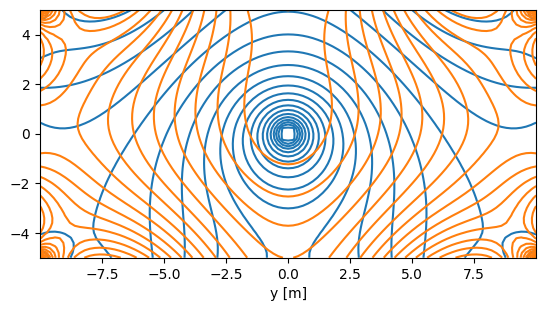

In [25]:
tiny = 1e-5
xgr = np.linspace(-10 + tiny, 10 - tiny, 101)
ygr = np.linspace(-5 + tiny, 5 - tiny, 51)
h = ml.headgrid(xgr, ygr)
plt.contour(xgr, ygr, h[0], levels=20, colors="C0")
plt.contour(xgr, ygr, h[1], levels=20, colors="C1")
plt.axis("scaled")
plt.xlabel("x [m]")
plt.xlabel("y [m]");

We can also see that the water balance isn't quite correct. In the first layer, along 3
sides, there is flow out of the building pit (negative numbers), which is not
what we would expect, and the total discharge flowing into the building pit should
equal the pumping discharge of the well (it's close but not quite right).

In [26]:
df = pd.DataFrame(
    index=np.arange(ml.aq.naq),
    columns=["S", "E", "N", "W"],
    data=ml.intnormflux(xy, ndeg=99),
)
df.index.name = "Layer"
df.columns.name = "Side"
df["total"] = df.sum(axis=1)
df.loc["total", :] = df.sum(axis=0)
df.round(1)

Side,S,E,N,W,total
Layer,,,,,
0,-0.7,-0.4,56.0,-0.4,54.4
1,19.2,10.4,5.5,10.4,45.6
total,18.6,10.0,61.5,10.0,100.1


Next, let's refine the leaky building pit, and see how that affects the solution. Let's
try a `refine_level` of 3.

In [27]:
mlr = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
bpitr = tml.LeakyBuildingPitMaq(
    mlr,
    xy,
    kaq=kh,
    z=z[1:],
    topboundary="conf",
    c=[1],
    layers=[0],
    res=res,
    refine_level=3,
)
wellr = tml.Well(mlr, 0.0, 0.0, Qw=Qw, rw=rw)
mlr.solve()

Number of elements, Number of equations: 51 , 193
...................................................
solution complete


Plot the contours. The results in the corners of the building pit seem a lot more
realistic, though there are still some visible minor irregularities in the top-left and
right corners.

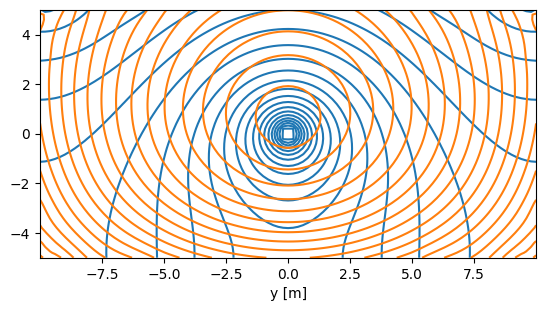

In [28]:
tiny = 1e-5
xgr = np.linspace(-10 + tiny, 10 - tiny, 101)
ygr = np.linspace(-5 + tiny, 5 - tiny, 51)
h = mlr.headgrid(xgr, ygr)
plt.contour(xgr, ygr, h[0], levels=20, colors="C0")
plt.contour(xgr, ygr, h[1], levels=20, colors="C1")
plt.axis("scaled")
plt.xlabel("x [m]")
plt.xlabel("y [m]");

The calculated discharge is now more realistic, with no discharge out of the building
pit in layer 0 and the total discharge is exactly equal to the discharge of the pumping
well.

In [29]:
df = pd.DataFrame(
    index=np.arange(mlr.aq.naq),
    columns=["S", "E", "N", "W"],
    data=mlr.intnormflux(xy, ndeg=99),
)
df.index.name = "Layer"
df.columns.name = "Side"
df["total"] = df.sum(axis=1)
df.loc["total", :] = df.sum(axis=0)
df.round(1)

Side,S,E,N,W,total
Layer,,,,,
0,0.6,0.1,54.9,0.1,55.9
1,20.2,8.4,7.2,8.4,44.1
total,20.9,8.5,62.1,8.5,100.0


## Global refine option

In the examples above the refine_level was defined in the elements that were meant to
be refined. This allows for fine-grained control over which elements should be refined
and by how much. This is the preferred method for specifying this information. However,
in certain situations it can be useful to globally set a refinement level.

This is possible by setting the `refine_level` in `ml.solve()`. Setting this keyword
argument to None (the default), uses the element-level settings, setting it to a number
will override the element settings.

In [30]:
ml = tml.ModelMaq(kaq=kh, z=z, c=[ctop, 1], topboundary="semi", hstar=0.0)
ls = tml.HeadLineSink(ml, 0, 0, 10, 10, hls=1.0)  # no refine_level specified
ml.solve(refine_level=3)

Number of elements, Number of equations: 4 , 3
....
solution complete


In [31]:
ml.elementlist

[ConstantStar with head  0.0,
 HeadLineSink from (0.0, 0.0) to (2.499999999999999, 2.499999999999999),
 HeadLineSink from (2.499999999999999, 2.499999999999999) to (7.5, 7.5),
 HeadLineSink from (7.5, 7.5) to (10.0, 10.0)]